In [18]:
# Load YOLO, train it 
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import numpy as np

model = YOLO('runs/detect/train/weights/best.pt')

In [22]:
%time
img = cv2.imread(r"V:\eye-dataset\eyes-dataset\images\img_010_1.png")
print(img.shape)

# Инференс с использованием модели
results = model(img, imgsz=1080, iou=0.1, conf=0.3, verbose=True)
print(results[0].boxes.conf)

CPU times: total: 0 ns
Wall time: 0 ns
(720, 1280, 3)

WARNING  imgsz=[1080] must be multiple of max stride 32, updating to [1088]
0: 640x1088 2 eyes, 2 iriss, 1 head, 31.8ms
Speed: 81.5ms preprocess, 31.8ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 1088)
tensor([0.8687, 0.8681, 0.8607, 0.8589, 0.8554], device='cuda:0')


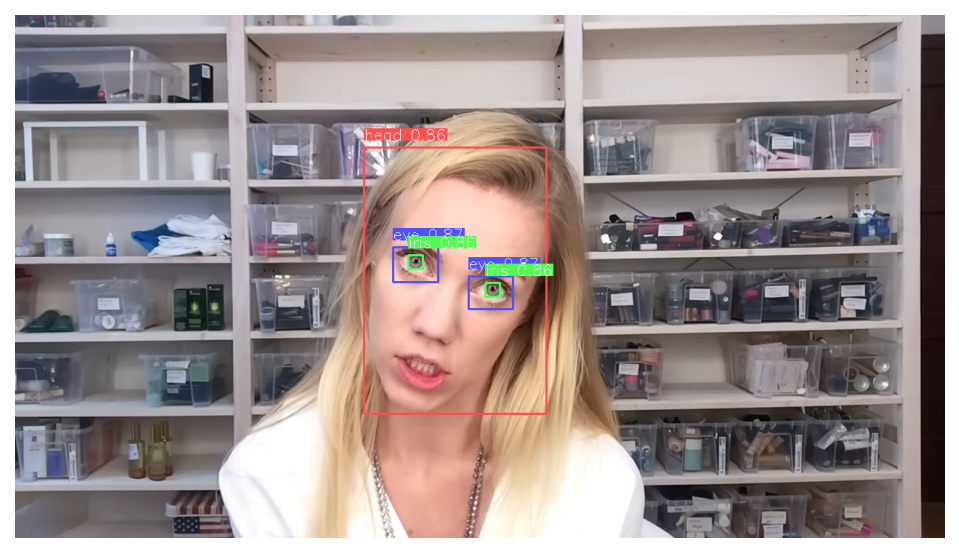

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Получение классов, имен классов и уверенностей
boxes = results[0].boxes.xyxy.cpu().numpy()  # Координаты bounding box [x1, y1, x2, y2]
classes = results[0].boxes.cls.cpu().numpy()
class_names = {0: 'eye', 1: 'iris', 2: 'head'}  # Словарь с именами классов
confs = results[0].boxes.conf.cpu().numpy()

# Создаем копию изображения для рисования
labeled_image = img.copy()

# Цвета для каждого класса (BGR формат)
colors = {
    'eye': (252, 80, 80),    # Красный для глаз
    'iris': (80, 252, 80),   # Зеленый для радужки
    'head': (80, 80, 252)    # Синий для головы
}

font_color = (255, 255, 255)  # Белый цвет текста

# Рисуем bounding boxes и подписи
for i in range(len(boxes)):
    box = boxes[i]
    class_index = int(classes[i])
    class_name = class_names[class_index]
    confidence = confs[i]
    color = colors[class_name]
    
    # Рисуем прямоугольник
    cv2.rectangle(labeled_image, 
                  (int(box[0]), int(box[1])), 
                  (int(box[2]), int(box[3])), 
                  color, 2)
    
    # Создаем подпись
    label = f"{class_name} {confidence:.2f}"
    
    # Размер текста и отступы
    font_scale = 0.7
    thickness = 1
    
    # Получаем размеры текста
    (text_width, text_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)
    
    # Рисуем подложку для текста
    cv2.rectangle(labeled_image,
                  (int(box[0]), int(box[1]) - text_height - 10),
                  (int(box[0]) + text_width, int(box[1]) - 10),
                  color, -1)
    
    # Рисуем текст
    cv2.putText(labeled_image, label,
                (int(box[0]), int(box[1]) - 10),
                cv2.FONT_HERSHEY_SIMPLEX, font_scale,
                font_color, thickness)

# Отображаем итоговое изображение
plt.figure(figsize=(8, 8), dpi=150)
labeled_image = cv2.cvtColor(labeled_image, cv2.COLOR_BGR2RGB)
plt.imshow(labeled_image)
plt.axis('off')
plt.show()

# Примерный код работы метода

In [10]:
import cv2
import numpy as np
from ultralytics import YOLO

# Загружаем модель YOLO
model = YOLO('runs/detect/train4/weights/best.pt')  # Модель должна детектировать глаза и радужки

# Размер виртуального экрана
VIRTUAL_SCREEN_WIDTH = 200
VIRTUAL_SCREEN_HEIGHT = 100

def calibrate(x_virt, y_virt):
    """Простое линейное преобразование в координаты виртуального экрана"""
    x_screen = int(x_virt * VIRTUAL_SCREEN_WIDTH)
    y_screen = int(y_virt * VIRTUAL_SCREEN_HEIGHT)
    return x_screen, y_screen

cap = cv2.VideoCapture(0)
cv2.namedWindow("Eye Tracking Demo")

# Для сглаживания движений
smooth_x, smooth_y = 0.1, 0.1
alpha = 0.7  # Коэффициент сглаживания

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Детекция объектов
    results = model(frame)
    
    # Собираем все обнаруженные глаза и радужки
    eyes = []
    irises = []
    
    for box in results[0].boxes:
        cls = int(box.cls)
        bbox = box.xyxy[0].tolist()
        if cls == 0:  # Класс "голова"
            pass
        if cls == 1:  # Класс "глаз"
            eyes.append(bbox)
        elif cls == 2:  # Класс "радужка"
            irises.append(bbox)
    
    # Если есть хотя бы один глаз и одна радужка
    if len(eyes) > 0 and len(irises) > 0:
        # Сопоставляем каждому глазу ближайшую радужку
        paired_data = []
        
        for eye in eyes:
            eye_center = [(eye[0] + eye[2]) / 2, (eye[1] + eye[3]) / 2]
            
            # Находим ближайшую радужку к этому глазу
            closest_iris = None
            min_distance = float('inf')
            
            for iris in irises:
                iris_center = [(iris[0] + iris[2]) / 2, (iris[1] + iris[3]) / 2]
                distance = np.sqrt((eye_center[0]-iris_center[0])**2 + (eye_center[1]-iris_center[1])**2)
                
                if distance < min_distance:
                    min_distance = distance
                    closest_iris = iris
            
            if closest_iris:
                # Нормализация координат радужки относительно глаза
                iris_center = [(closest_iris[0] + closest_iris[2]) / 2, 
                              (closest_iris[1] + closest_iris[3]) / 2]
                
                x_norm = (iris_center[0] - eye[0]) / (eye[2] - eye[0])
                y_norm = (iris_center[1] - eye[1]) / (eye[3] - eye[1])
                
                paired_data.append((x_norm, y_norm))
        
        # Усредняем координаты по всем обнаруженным глазам
        if paired_data:
            avg_x = sum(p[0] for p in paired_data) / len(paired_data)
            avg_y = sum(p[1] for p in paired_data) / len(paired_data)
            
            # Преобразование в виртуальные координаты
            cursor_x, cursor_y = calibrate(avg_x, avg_y)
            
            # Сглаживание
            smooth_x = alpha * smooth_x + (1 - alpha) * cursor_x
            smooth_y = alpha * smooth_y + (1 - alpha) * cursor_y
            
            # Отрисовка виртуального экрана
            virtual_screen = np.zeros((VIRTUAL_SCREEN_HEIGHT, VIRTUAL_SCREEN_WIDTH, 3), dtype=np.uint8)
            cv2.circle(virtual_screen, (int(smooth_x), int(smooth_y)), 5, (0, 0, 255), -1)
            cv2.imshow("Virtual Screen", virtual_screen)
    
    # Отрисовка детекций на исходном кадре
    annotated_frame = results[0].plot()
    cv2.imshow("Eye Tracking Demo", annotated_frame)
    
    if cv2.waitKey(1) == 27:  # ESC для выхода
        break

cap.release()
cv2.destroyAllWindows()
